# Нерівність у результатах ЗНО-2016

Аналіз та візуалізація даних для відповідної статті:

http://cedos.org.ua/uk/osvita/nerivnist-navchalnykh-dosiahnen-v-ukrainskykh-shkolakh-za-rezultatamy-zno-2016

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [2]:
%matplotlib inline

Оригінальний файл займає понад 400 Мб, але стиснутий через gzip файл має вже в 10 разів менший обсяг. 

In [5]:
zno = pd.read_csv('OpenData2016new.csv.gz', sep = ';', encoding='cp1251', 
                  na_values='null', compression='gzip')

In [6]:
subjs = ['Ukr', 'Hist', 'Math', 'Phys', 'Chem', 'Bio', 'Geo', 'Eng', 'Fr', 'Deu', 'Sp', 'Rus']

Допоміжні функції та виведення нових змінних (для міських шкіл та для елітних шкіл).

In [7]:
def normalize(data, col):
    m = data[col].mean()
    sd = data[col].std()
    return (data[col]-m)/sd

for subj in subjs:
    zno[subj+'Norm'] = normalize(zno, subj+'Ball')
    
ballcols = [col for col in zno.columns if col.endswith('Ball')]
normcols = [col for col in zno.columns if col.endswith('Norm')]
scorecols = [col for col in zno.columns if ('Ball100' in col)]

In [8]:
def floatify(data, col):
    return data[col].astype(str).str.replace(',','.').str.replace('null','0').astype(float).replace(0, np.nan)

for col in scorecols:
    zno[col] = floatify(zno, col)

In [9]:
def gini(series):
    l = list(series.dropna())
    if len(l) == 0:
        return np.nan
    sorted_list = sorted(l)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(l) / 2.
    return (fair_area - area) / fair_area

In [10]:
def get_gini_grouped(df, group_by, subj, save_csv = False):
    """
    Індекс Джині для обраного предмета (subj), згрупованого за groupby.
    Рахує індекс тільки для груп, де є більше 5 членів.
    Також додає count (кількість членів групи) та mean (середній тестовий бал)
    Зберігає готову таблицю в csv-файл, якщо обрано таку опцію.
    subj - один із ['Ukr', 'Hist', 'Math', 'Phys', 'Chem', 
    'Bio', 'Geo', 'Eng', 'Fr', 'Deu', 'Sp', 'Rus']
    """
    grouped = df.groupby(group_by)[subj+'Ball'].agg(['mean', 'count', gini])
    grouped = grouped[grouped['count'] > 5].sort_values(by='gini2')
    if save_csv:
        gr2 = grouped.copy()
        gr2.columns = ['Середній тестовий бал', 'Кількість', 'Індекс Джині']
        fname = 'gini_{subj}_by_{by}.csv'.format(subj=subj, by=group_by)
        gr2.to_csv(fname, encoding='utf-8')
    return grouped

In [11]:
def groups_variation(zno, subj, group):
    """
    Calculates within- and between- group variation in given data (zno_scores),
    by given subj, by given group.
    """
    subjcol = subj+'Ball'
    data = zno.dropna(subset=[subjcol, group])
    tot_mean = data[subjcol].mean()
    grouped = data.groupby(group)
    subjscores = data[subjcol]
    # within-group sum of squares
    wss = 0
    for j in grouped.groups.keys():
        gr_mean = grouped[subjcol].mean().loc[j]
        gss = sum(((subjscores[i] - gr_mean)**2) for i in grouped.groups[j])
        wss += gss
    # between-group sum of squares
    bss = sum(len(grouped.groups[j])*((grouped[subjcol].mean().loc[j] - tot_mean)**2) for j in grouped.groups.keys())
    # total sum of squares
    tss = sum((x - tot_mean)**2 for x in subjscores)
    # check if sum of bss and wss equals tss
    assert ((bss+wss) - tss) < 1
    # calculate proportion
    bvar = bss/tss
    wvar = wss/tss
    return bvar, wvar

In [12]:
def is_urban(row):
    areaname = row['AreaName']
    if areaname.startswith('м.'):
        return 'місто'
    else:
        tername = row['TerName']
        if tername.startswith('м.') or tername.startswith('смт'):
            return 'місто'
        else:
            return 'село'
    
zno['urban'] = zno.apply(is_urban, axis=1)

In [13]:
types = zno['EOTypeName'].dropna().unique()
def is_elite(row):
    if row['EOTypeName'] in ['гімназія', 'спеціалізована школа', 'ліцей', 'колегіум', 'колеж']:
        return 'Елітна школа'
    elif row['EOTypeName'] in types:
        return 'Звичайна школа'
    else:
        return np.nan
    
zno['elite_school'] = zno.apply(is_elite, axis=1)

Надалі всі графіки більш-менш самі себе пояснюють. Те саме стосується вирахування інших статистичних індикаторів, які обійшлись без графіка.

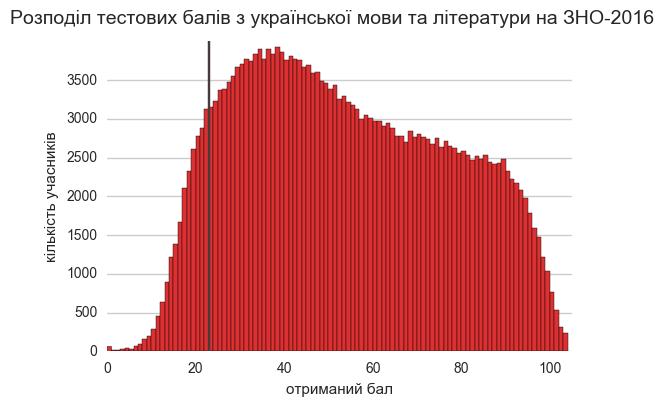

In [14]:
ax1 = sns.distplot(zno[zno['UkrBall'].notnull()]['UkrBall'], 
                   kde=False, bins=range(105), color='#DD3032', hist_kws={'alpha': 1})
plt.axvline(x=23, color='#473A3A')
ax1.set(xlabel='отриманий бал', ylabel='кількість учасників')
ax1.set_xlim(xmax=105)
ax1.set_ylim(ymax=3999)
plt.suptitle('Розподіл тестових балів з української мови та літератури на ЗНО-2016', size=14)
ax1.yaxis.grid(True)
sns.despine(left=True, bottom=True)

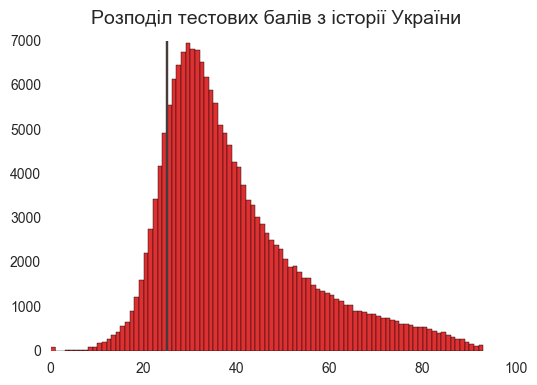

In [15]:
ax1_2 = sns.distplot(zno.dropna(subset=['HistBall'])['HistBall'], 
                   kde=False, bins=range(94), color='#DD3032', hist_kws={'alpha': 1})
plt.axvline(x=25, color='#473A3A')
ax1_2.set(xlabel='')
plt.suptitle('Розподіл тестових балів з історії України', size=14)
sns.despine(left=True, bottom=True)

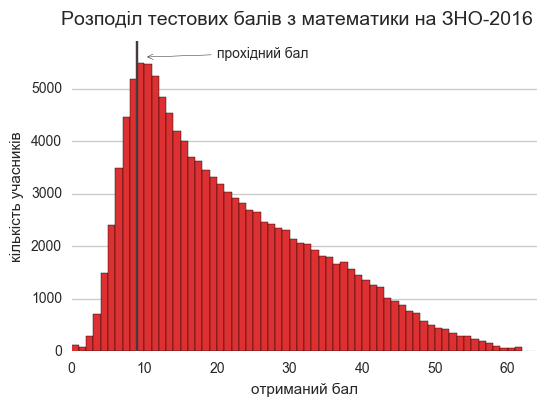

In [49]:
ax2 = sns.distplot(zno[zno['MathBall'].notnull()]['MathBall'], 
                   kde=False, bins=range(63), color='#DD3032', hist_kws={'alpha': 1})
plt.axvline(x=9, color='#473A3A')
ax2.set(xlabel='отриманий бал', ylabel='кількість учасників')
ax2.set_xlim(xmax=64)
ax2.set_ylim(ymax=5900)
plt.suptitle('Розподіл тестових балів з математики на ЗНО-2016', size=14)
ax2.yaxis.grid(True)
plt.annotate('прохідний бал', [10, 5600], xytext=[20, 5600], arrowprops={'arrowstyle': '->'})
sns.despine(left=True, bottom=True)

Індекс Джині для різних предметів

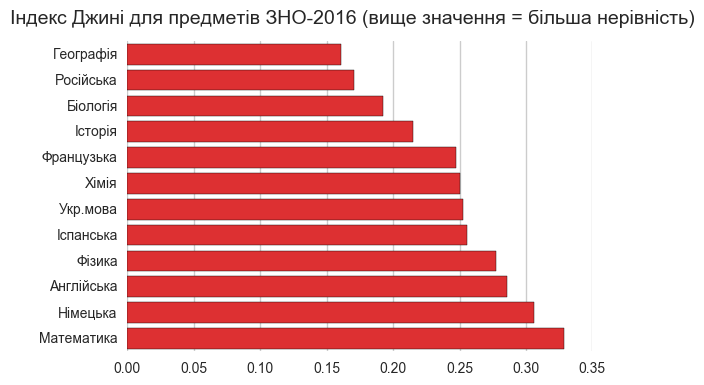

In [18]:
ukrsubjs = ['Укр.мова', 'Історія', 'Математика', 'Фізика', 'Хімія', 'Біологія', 'Географія', 
            'Англійська', 'Французька', 'Німецька', 'Іспанська', 'Російська']
ukrsubjdic = dict(zip(ballcols, ukrsubjs))

subjgini = (zno[ballcols]
    .apply(gini)
    .rename(index=ukrsubjdic)
    .reset_index()
    .rename(columns={'index': 'subj', 0: 'gini'}).sort_values(by='gini'))
ax3 = sns.barplot(data = subjgini, x = 'gini', y = 'subj', color = '#DD3032', saturation=1)
ax3.set(ylabel='',
        xlabel='')
plt.suptitle('Індекс Джині для предметів ЗНО-2016 (вище значення = більша нерівність)', 
             size=14)
ax3.xaxis.grid(True)
sns.despine(left=True, bottom=True)

Розподіл за школами з мови та математики

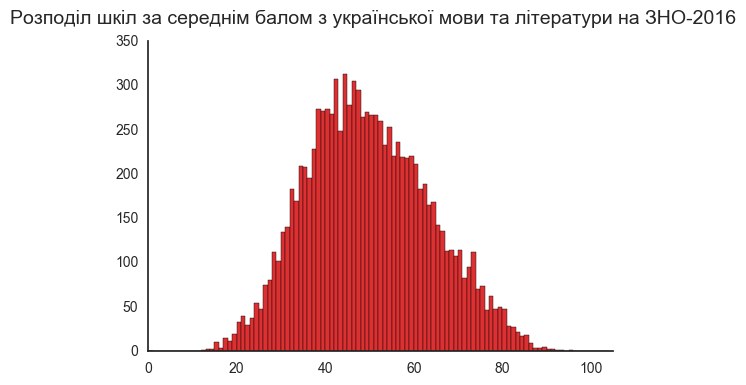

In [20]:
ax4 = sns.distplot(zno.groupby('EOName')['UkrBall'].mean().dropna(), 
                   bins=np.arange(0, 105, 1),
                   kde=False, color='#DD3032', hist_kws={'alpha': 1})
ax4.set(xlabel='')
ax4.set_xlim(xmax=105)
plt.suptitle(
    'Розподіл шкіл за середнім балом з української мови та літератури на ЗНО-2016', 
    size=14)
sns.despine()

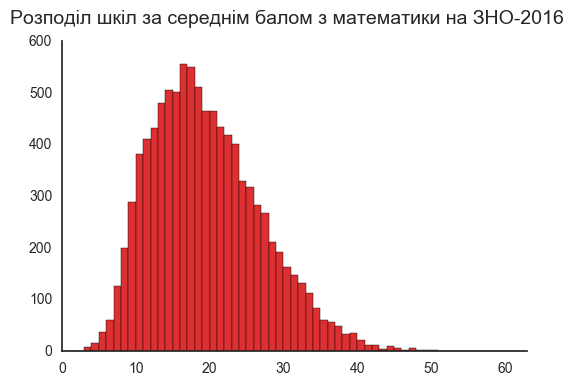

In [21]:
ax5 = sns.distplot(zno.groupby('EOName')['MathBall'].mean().dropna(), 
                   bins=np.arange(0, 63, 1),
                   kde=False, color='#DD3032', hist_kws={'alpha': 1})
ax5.set(xlabel='')
ax5.set_xlim(xmax=63)
plt.suptitle('Розподіл шкіл за середнім балом з математики на ЗНО-2016', 
             size=14)
sns.despine()

Тепер порівняємо нерівність всередині шкіл з результатами шкіл.

In [22]:
schoolres = zno.dropna(subset=['EOName', 'UkrBall']).groupby('EOName').filter(
    lambda x: len(x) > 5).groupby('EOName')['UkrBall'].agg(['mean', gini])

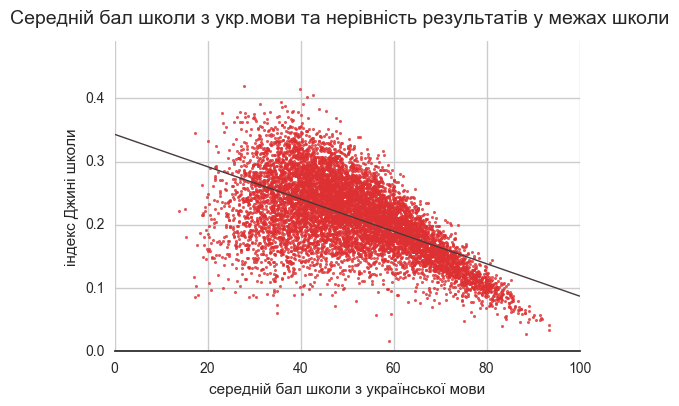

In [23]:
ax6 = sns.regplot(data=schoolres, x='mean', y='gini',
                  color='#DD3032', line_kws={'color': '#473A3A', 'linewidth': 1}, 
                  marker='.', ci=None, x_ci=None)
ax6.set(xlabel='cередній бал школи з української мови', ylabel='індекс Джині школи')
ax6.set_ylim(ymin=0, ymax=0.49)
#ax6.set_xlim(xmax=101)
plt.suptitle('Середній бал школи з укр.мови та нерівність результатів у межах школи', size=14)
plt.grid(True)
sns.despine(left=True)

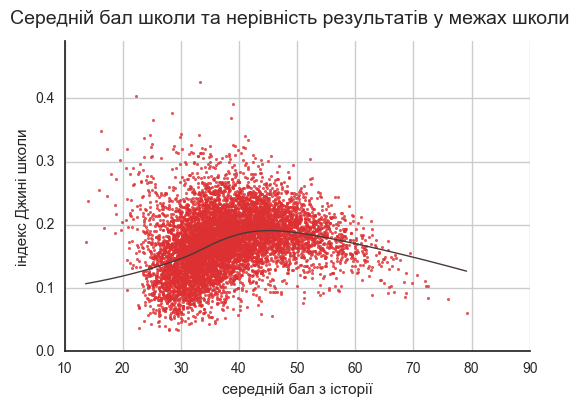

In [24]:
histres = zno.dropna(subset=['EOName', 'HistBall']).groupby('EOName').filter(
    lambda x: len(x) > 5).groupby('EOName')['HistBall'].agg(['mean', gini])
ax61 = sns.regplot(data=histres, x='mean', y='gini', lowess=True,
                  color='#DD3032', line_kws={'color': '#473A3A', 'linewidth': 1}, 
                   marker='.', ci=None, x_ci=None)
ax61.set(xlabel='cередній бал з історії', ylabel='індекс Джині школи')
ax61.set_ylim(ymin=0, ymax=0.49)
#ax6.set_xlim(xmax=101)
plt.suptitle('Середній бал школи та нерівність результатів у межах школи', size=14)
plt.grid(True)
sns.despine()

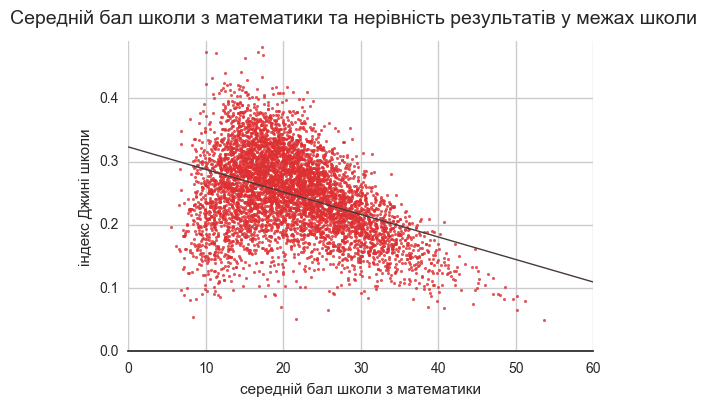

In [26]:
mathres = zno.dropna(subset=['EOName', 'MathBall']).groupby('EOName').filter(
    lambda x: len(x) > 5).groupby('EOName')['MathBall'].agg(['mean', gini])
ax62 = sns.regplot(data=mathres, x='mean', y='gini', lowess=False,
                  color='#DD3032', line_kws={'color': '#473A3A', 'linewidth': 1}, 
                   marker='.', ci=None, x_ci=None)
ax62.set(xlabel='cередній бал школи з математики', ylabel='індекс Джині школи')
ax62.set_ylim(ymin=0, ymax=0.49)
#ax6.set_xlim(xmax=101)
plt.suptitle('Середній бал школи з математики та нерівність результатів у межах школи', size=14)
plt.grid(True)
sns.despine(left=True)

In [27]:
typegini = (zno.groupby('EOTypeName')
            .filter(lambda x: len(x) > 100)
            .dropna(subset=['EOTypeName','UkrBall'])
            .groupby('EOTypeName')['UkrBall'].agg(['mean', gini])
            .reset_index()
            .rename(columns={'EOTypeName': 'type'})
            .sort_values('gini'))

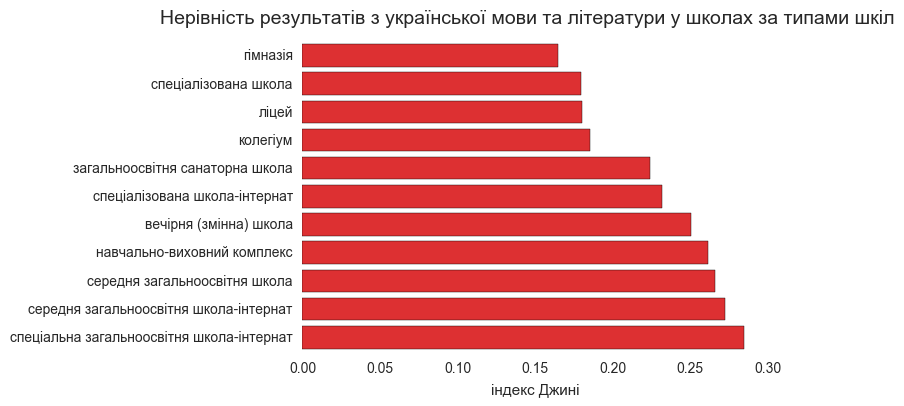

In [28]:
ax7 = sns.barplot(data = typegini, x = 'gini', y = 'type', color = '#DD3032', saturation=1)
ax7.set(ylabel='',
        xlabel='індекс Джині')
plt.suptitle('Нерівність результатів з української мови та літератури у школах за типами шкіл', size=14)
sns.despine(left=True, bottom=True)

Тепер не графіки, а інші корисні цифри для використання у статті.

In [29]:
for col in ballcols:
    g = gini(zno[col])
    s = 'Індекс Джині з предмету {} становить {:.3f}'.format(ukrsubjdic[col].lower(), g)
    print(s)

Індекс Джині з предмету укр.мова становить 0.252
Індекс Джині з предмету історія становить 0.215
Індекс Джині з предмету математика становить 0.329
Індекс Джині з предмету фізика становить 0.277
Індекс Джині з предмету хімія становить 0.250
Індекс Джині з предмету біологія становить 0.193
Індекс Джині з предмету географія становить 0.161
Індекс Джині з предмету англійська становить 0.286
Індекс Джині з предмету французька становить 0.248
Індекс Джині з предмету німецька становить 0.306
Індекс Джині з предмету іспанська становить 0.255
Індекс Джині з предмету російська становить 0.171


In [30]:
for col in ballcols:
    m = zno[col].mode()[0]
    mx = zno[col].max()
    s = 'Найпоширеніший бал із предмету {} - {}, при тому що максимальний - {}'.format(
        ukrsubjdic[col].lower(), int(m), int(mx))
    print(s)
# російська - 88

Найпоширеніший бал із предмету укр.мова - 38, при тому що максимальний - 104
Найпоширеніший бал із предмету історія - 29, при тому що максимальний - 94
Найпоширеніший бал із предмету математика - 9, при тому що максимальний - 62
Найпоширеніший бал із предмету фізика - 13, при тому що максимальний - 56
Найпоширеніший бал із предмету хімія - 21, при тому що максимальний - 80
Найпоширеніший бал із предмету біологія - 30, при тому що максимальний - 76
Найпоширеніший бал із предмету географія - 39, при тому що максимальний - 92
Найпоширеніший бал із предмету англійська - 9, при тому що максимальний - 56
Найпоширеніший бал із предмету французька - 15, при тому що максимальний - 56
Найпоширеніший бал із предмету німецька - 9, при тому що максимальний - 56
Найпоширеніший бал із предмету іспанська - 43, при тому що максимальний - 56
Найпоширеніший бал із предмету російська - 40, при тому що максимальний - 83


In [31]:
for col in ballcols:
    med = zno[col].median()
    mx = zno[col].max()
    medp = (med/mx)*100
    s = 'Медіанний бал із предмету {} - {}, що становить {:.2f} % від максимуму'.format(
        ukrsubjdic[col].lower(), int(med), medp)
    print(s)

Медіанний бал із предмету укр.мова - 51, що становить 49.04 % від максимуму
Медіанний бал із предмету історія - 35, що становить 37.23 % від максимуму
Медіанний бал із предмету математика - 18, що становить 29.03 % від максимуму
Медіанний бал із предмету фізика - 16, що становить 28.57 % від максимуму
Медіанний бал із предмету хімія - 32, що становить 40.00 % від максимуму
Медіанний бал із предмету біологія - 35, що становить 46.05 % від максимуму
Медіанний бал із предмету географія - 45, що становить 48.91 % від максимуму
Медіанний бал із предмету англійська - 25, що становить 44.64 % від максимуму
Медіанний бал із предмету французька - 32, що становить 57.14 % від максимуму
Медіанний бал із предмету німецька - 27, що становить 48.21 % від максимуму
Медіанний бал із предмету іспанська - 33, що становить 58.93 % від максимуму
Медіанний бал із предмету російська - 42, що становить 50.60 % від максимуму


In [32]:
zno2 = zno.dropna(subset=['EOName'])
for col in ballcols:
    data = zno2.dropna(subset=[col]).groupby('EOName').filter(lambda x: len(x) > 5)
    corr = data.groupby('EOName')[col].agg(['mean', gini]).corr().loc['mean', 'gini']
    s = 'Кореляція між середнім результатом школи з предмету {} та нерівністю в межах школи становить {:.3f}'.format(
        ukrsubjdic[col].lower(), corr)
    print(s)

Кореляція між середнім результатом школи з предмету укр.мова та нерівністю в межах школи становить -0.591
Кореляція між середнім результатом школи з предмету історія та нерівністю в межах школи становить 0.234
Кореляція між середнім результатом школи з предмету математика та нерівністю в межах школи становить -0.398
Кореляція між середнім результатом школи з предмету фізика та нерівністю в межах школи становить -0.002
Кореляція між середнім результатом школи з предмету хімія та нерівністю в межах школи становить -0.409
Кореляція між середнім результатом школи з предмету біологія та нерівністю в межах школи становить -0.012
Кореляція між середнім результатом школи з предмету географія та нерівністю в межах школи становить -0.081
Кореляція між середнім результатом школи з предмету англійська та нерівністю в межах школи становить -0.682
Кореляція між середнім результатом школи з предмету французька та нерівністю в межах школи становить -0.484
Кореляція між середнім результатом школи з пре

In [33]:
zno3 = zno.dropna(subset=['EOTypeName'])
for col in ballcols[:10]:
    data = zno3.dropna(subset=[col]).groupby('EOTypeName').filter(lambda x: len(x) > 5)
    gymscore = data.groupby('EOTypeName')[col].agg(['mean', gini]).loc['гімназія', 'gini']
    normscore = data.groupby('EOTypeName')[col].agg(['mean', gini]).loc['середня загальноосвітня школа', 'gini']
    s = 'Індекс Джині з предмету {} в гімназіях становить {:.3f}, у середніх ЗОШ - {:.3f}'.format(
        ukrsubjdic[col].lower(), gymscore, normscore)
    print(s)

Індекс Джині з предмету укр.мова в гімназіях становить 0.165, у середніх ЗОШ - 0.266
Індекс Джині з предмету історія в гімназіях становить 0.214, у середніх ЗОШ - 0.216
Індекс Джині з предмету математика в гімназіях становить 0.245, у середніх ЗОШ - 0.321
Індекс Джині з предмету фізика в гімназіях становить 0.260, у середніх ЗОШ - 0.256
Індекс Джині з предмету хімія в гімназіях становить 0.205, у середніх ЗОШ - 0.242
Індекс Джині з предмету біологія в гімназіях становить 0.192, у середніх ЗОШ - 0.191
Індекс Джині з предмету географія в гімназіях становить 0.157, у середніх ЗОШ - 0.161
Індекс Джині з предмету англійська в гімназіях становить 0.209, у середніх ЗОШ - 0.294
Індекс Джині з предмету французька в гімназіях становить 0.174, у середніх ЗОШ - 0.251
Індекс Джині з предмету німецька в гімназіях становить 0.193, у середніх ЗОШ - 0.322


In [34]:
for col in ballcols:
    data = zno.dropna(subset=[col]).groupby('EOName').filter(lambda x: len(x) > 5)
    data_gr = data.groupby('EOName')[col].agg(['mean', gini])
    s = """Для предмету {}, середня нерівність всередині школи становить {:.3f},
    а нерівність між школами (середніми балами шкіл) - {:.3f}
    """.format(ukrsubjdic[col].lower(), data_gr['gini'].mean(), gini(data_gr['mean']))
    print(s)

Для предмету укр.мова, середня нерівність всередині школи становить 0.213,
    а нерівність між школами (середніми балами шкіл) - 0.152
    
Для предмету історія, середня нерівність всередині школи становить 0.173,
    а нерівність між школами (середніми балами шкіл) - 0.119
    
Для предмету математика, середня нерівність всередині школи становить 0.249,
    а нерівність між школами (середніми балами шкіл) - 0.194
    
Для предмету фізика, середня нерівність всередині школи становить 0.199,
    а нерівність між школами (середніми балами шкіл) - 0.172
    
Для предмету хімія, середня нерівність всередині школи становить 0.169,
    а нерівність між школами (середніми балами шкіл) - 0.129
    
Для предмету біологія, середня нерівність всередині школи становить 0.153,
    а нерівність між школами (середніми балами шкіл) - 0.110
    
Для предмету географія, середня нерівність всередині школи становить 0.133,
    а нерівність між школами (середніми балами шкіл) - 0.080
    
Для предмету анг

Функція, яка вираховує частку міжгрупової та внутрішньогрупової варіації в результатах ЗНО, працює дуже довго через великий обсяг інформації, тому тут тільки вже вирахувані результати.

In [36]:
"""for subj in ['Ukr', 'Hist', 'Math']:
    bvar, wvar = groups_variation(zno, subj, 'EOName')
    s = 'Для предмету {}, {:.2f}% варіації в балах ЗНО пояснюється міжшкільною нерівністю, {:.2f}% - всередині-шкільною'.format(
        ukrsubjdic[subj+'Ball'].lower(), bvar*100, wvar*100)
    print(s)
"""
# дуже довго працює функція
s = """
Для предмету укр.мова, 36.45% варіації в балах ЗНО пояснюється міжшкільною нерівністю, 63.55% - всередині-шкільною
Для предмету історія, 28.14% варіації в балах ЗНО пояснюється міжшкільною нерівністю, 71.86% - всередині-шкільною
Для предмету математика, 40.88% варіації в балах ЗНО пояснюється міжшкільною нерівністю, 59.12% - всередині-шкільною
"""
print(s)


Для предмету укр.мова, 36.45% варіації в балах ЗНО пояснюється міжшкільною нерівністю, 63.55% - всередині-шкільною
Для предмету історія, 28.14% варіації в балах ЗНО пояснюється міжшкільною нерівністю, 71.86% - всередині-шкільною
Для предмету математика, 40.88% варіації в балах ЗНО пояснюється міжшкільною нерівністю, 59.12% - всередині-шкільною



In [37]:
for col in ballcols:
    mx = zno[col].max()
    data = zno[col].apply(lambda x: (x/mx)*100)
    quants = data.dropna().quantile([0.1, 0.9])
    q1 = quants[0.1]
    q9 = quants[0.9]
    q1data = data[data <= q1]
    q9data = data[data >= q9]
    meandiv = q9data.mean() / q1data.mean()
    s = 'Середній бал у верхніх 10% учнів за предметом {} у {:.2f} разів більший за середній бал 10% нижчих учнів'.format(
        ukrsubjdic[col].lower(), meandiv)
    print(s)

Середній бал у верхніх 10% учнів за предметом укр.мова у 5.06 разів більший за середній бал 10% нижчих учнів
Середній бал у верхніх 10% учнів за предметом історія у 3.71 разів більший за середній бал 10% нижчих учнів
Середній бал у верхніх 10% учнів за предметом математика у 8.08 разів більший за середній бал 10% нижчих учнів
Середній бал у верхніх 10% учнів за предметом фізика у 5.35 разів більший за середній бал 10% нижчих учнів
Середній бал у верхніх 10% учнів за предметом хімія у 4.33 разів більший за середній бал 10% нижчих учнів
Середній бал у верхніх 10% учнів за предметом біологія у 3.19 разів більший за середній бал 10% нижчих учнів
Середній бал у верхніх 10% учнів за предметом географія у 2.63 разів більший за середній бал 10% нижчих учнів
Середній бал у верхніх 10% учнів за предметом англійська у 6.62 разів більший за середній бал 10% нижчих учнів
Середній бал у верхніх 10% учнів за предметом французька у 4.44 разів більший за середній бал 10% нижчих учнів
Середній бал у вер

In [38]:
urbansubjgini = (zno.groupby('urban')[ballcols]
     .agg(gini)
     .rename(columns=ukrsubjdic)
     .transpose()
     .reset_index()
     .rename(columns={'index': 'subj'}))

long_subjgini = pd.melt(urbansubjgini, value_vars=['місто', 'село'], id_vars='subj').sort_values('value')

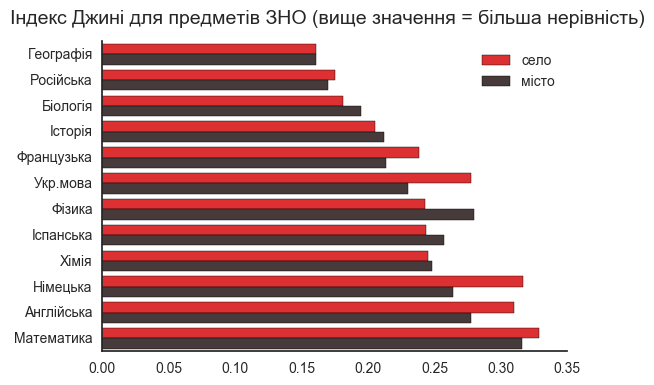

In [39]:
ax8 = sns.barplot(data = long_subjgini, x = 'value', y = 'subj', hue = 'urban', 
                  palette = {'село': '#DD3032', 'місто': '#473A3A'}, 
                  saturation=1)
ax8.set(ylabel='',
        xlabel='')
plt.suptitle('Індекс Джині для предметів ЗНО (вище значення = більша нерівність)', size=14)
plt.legend(title=None)
sns.despine()

In [40]:
zno4 = zno.dropna(subset=['EOName', 'EOTypeName']).groupby('EOName').filter(lambda x: len(x) > 5)
for col in ballcols[:10]:
    data = zno4.dropna(subset=[col]).groupby('EOTypeName').filter(lambda x: len(x) > 5)
    ginis = data.groupby(['EOName', 'EOTypeName'])[col].mean().reset_index().groupby('EOTypeName').agg(gini)
    gymscore = ginis.loc['гімназія', col]
    normscore = ginis.loc['середня загальноосвітня школа', col]
    s = 'Індекс Джині серед середніх балів шкіл з предмету {} серед гімназій становить {:.3f}, серед середніх ЗОШ - {:.3f}'.format(
        ukrsubjdic[col].lower(), gymscore, normscore)
    print(s)

Індекс Джині серед середніх балів шкіл з предмету укр.мова серед гімназій становить 0.094, серед середніх ЗОШ - 0.138
Індекс Джині серед середніх балів шкіл з предмету історія серед гімназій становить 0.105, серед середніх ЗОШ - 0.108
Індекс Джині серед середніх балів шкіл з предмету математика серед гімназій становить 0.144, серед середніх ЗОШ - 0.196
Індекс Джині серед середніх балів шкіл з предмету фізика серед гімназій становить 0.190, серед середніх ЗОШ - 0.204
Індекс Джині серед середніх балів шкіл з предмету хімія серед гімназій становить 0.157, серед середніх ЗОШ - 0.200
Індекс Джині серед середніх балів шкіл з предмету біологія серед гімназій становить 0.121, серед середніх ЗОШ - 0.120
Індекс Джині серед середніх балів шкіл з предмету географія серед гімназій становить 0.092, серед середніх ЗОШ - 0.109
Індекс Джині серед середніх балів шкіл з предмету англійська серед гімназій становить 0.146, серед середніх ЗОШ - 0.205
Індекс Джині серед середніх балів шкіл з предмету француз

In [44]:
import warnings
warnings.filterwarnings("ignore")

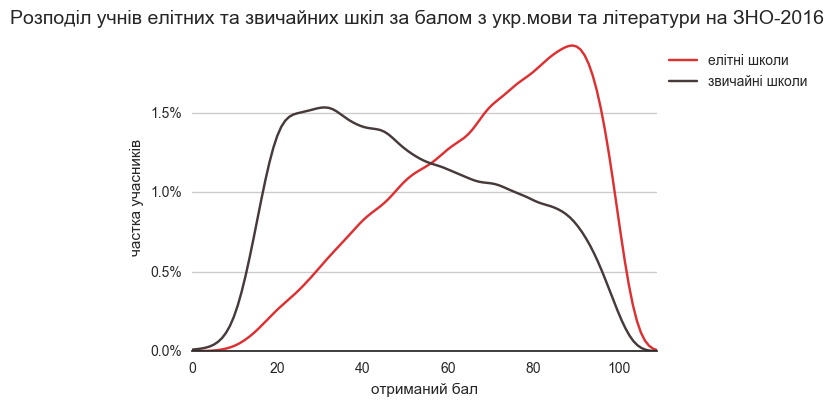

In [45]:
fig, ax9 = plt.subplots()
sns.distplot(zno[zno['elite_school']=='Елітна школа']['UkrBall'],
                    hist=False, color='#DD3032', hist_kws={'alpha': 0.5}, ax=ax9, bins=range(105))
sns.distplot(zno[zno['elite_school']=='Звичайна школа']['UkrBall'],
                    hist=False, color='#473A3A', hist_kws={'alpha': 0.5}, ax=ax9, bins=range(105))
ax9.set(xlabel='отриманий бал', ylabel='частка учасників')
ax9.set_xlim(xmin=0, xmax=109)
ax9.set_ylim(ymax=0.0195)
plt.suptitle(
    'Розподіл учнів елітних та звичайних шкіл за балом з укр.мови та літератури на ЗНО-2016', 
    size=14)
import matplotlib.lines as mlines
new_handles9 = [mlines.Line2D([], [], color = '#DD3032'), mlines.Line2D([], [], color='#473A3A')]
ax9.legend(new_handles9, ['елітні школи', 'звичайні школи'], bbox_to_anchor=(1.35,1))
ax9.set_yticklabels(['{:.1f}%'.format(tl*100) for tl in ax9.get_yticks()])
ax9.yaxis.grid(True)
sns.despine(left=True)

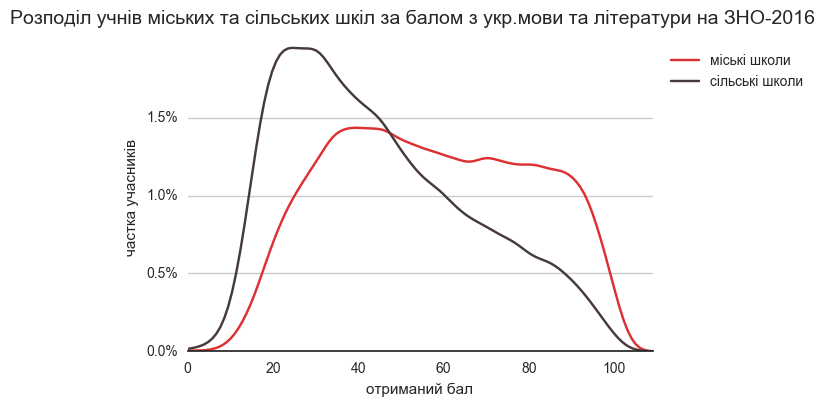

In [46]:
fig, ax10 = plt.subplots()
sns.distplot(zno[zno['urban']=='місто']['UkrBall'],
                    hist=False, color='#DD3032', hist_kws={'alpha': 0.5}, ax=ax10, bins=range(105))
sns.distplot(zno[zno['urban']=='село']['UkrBall'],
                    hist=False, color='#473A3A', hist_kws={'alpha': 0.5}, ax=ax10, bins=range(105))
ax10.set(xlabel='отриманий бал', ylabel='частка учасників')
ax10.set_xlim(xmin=0, xmax=109)
ax10.set_ylim(ymax=0.0199)
plt.suptitle(
    'Розподіл учнів міських та сільських шкіл за балом з укр.мови та літератури на ЗНО-2016', 
    size=14)
new_handles10 = [mlines.Line2D([], [], color = '#DD3032'), mlines.Line2D([], [], color='#473A3A')]
ax10.legend(new_handles10, ['міські школи', 'сільські школи'], bbox_to_anchor=(1.35,1))
ax10.set_yticklabels(['{:.1f}%'.format(tl*100) for tl in ax10.get_yticks()])
ax10.yaxis.grid(True)
sns.despine(left=True)

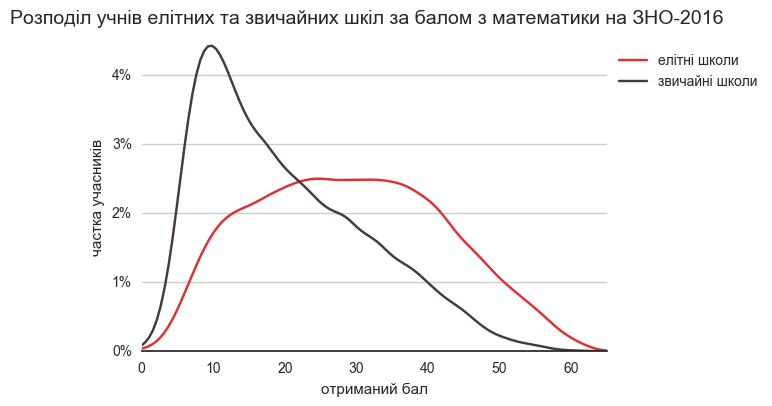

In [47]:
fig, ax11 = plt.subplots()
sns.distplot(zno[zno['elite_school']=='Елітна школа']['MathBall'],
             hist=False, color='#DD3032', hist_kws={'alpha': 0.5}, 
             ax=ax11, bins=range(63))
sns.distplot(zno[zno['elite_school']=='Звичайна школа']['MathBall'],
             hist=False, color='#473A3A', hist_kws={'alpha': 0.5}, 
             ax=ax11, bins=range(63))
ax11.set(xlabel='отриманий бал', ylabel='частка учасників')
ax11.set_xlim(xmin=0, xmax=65)
ax11.set_ylim(ymax=0.0449)
plt.suptitle(
    'Розподіл учнів елітних та звичайних шкіл за балом з математики на ЗНО-2016', 
    size=14)
import matplotlib.lines as mlines
new_handles11 = [mlines.Line2D([], [], color = '#DD3032'), mlines.Line2D([], [], color='#473A3A')]
ax11.legend(new_handles11, ['елітні школи', 'звичайні школи'], bbox_to_anchor=(1.35,1))
ax11.yaxis.grid(True)
ax11.set_yticks(np.arange(0,0.05, 0.01))
ax11.set_yticklabels(['{:.0f}%'.format(tl*100) for tl in ax11.get_yticks()])
sns.despine(left=True)

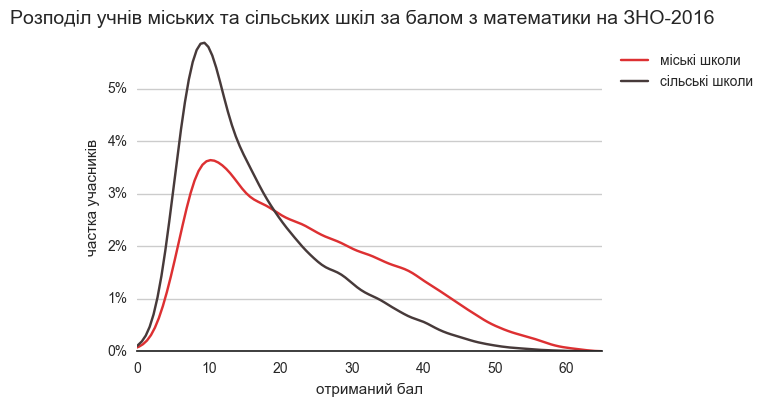

In [48]:
fig, ax12 = plt.subplots()
sns.distplot(zno[zno['urban']=='місто']['MathBall'],
             hist=False, color='#DD3032', hist_kws={'alpha': 0.5}, 
             ax=ax12, bins=range(63))
sns.distplot(zno[zno['urban']=='село']['MathBall'],
             hist=False, color='#473A3A', hist_kws={'alpha': 0.5}, 
             ax=ax12, bins=range(63))
ax12.set(xlabel='отриманий бал', ylabel='частка учасників')
ax12.set_xlim(xmin=0, xmax=65)
ax12.set_ylim(ymax=0.059)
plt.suptitle(
    'Розподіл учнів міських та сільських шкіл за балом з математики на ЗНО-2016', 
    size=14)
new_handles12 = [mlines.Line2D([], [], color = '#DD3032'), 
                 mlines.Line2D([], [], color='#473A3A')]
ax12.legend(new_handles12, ['міські школи', 'сільські школи'], bbox_to_anchor=(1.35,1))
ax12.set_yticklabels(['{:.0f}%'.format(tl*100) for tl in ax12.get_yticks()])
ax12.yaxis.grid(True)
sns.despine(left=True)